<div align="center">

## 294A: Final Project

#### Sindhu Dinesh Raju

June 13, 2024
</div>

#### Introduction & Empirical Question

This project attempts to use various regression techniques to analyze the determinants of housing prices in California using 1990 Census data. The empirical question it seeks to answer is: "What are the key determinants of housing prices in California based on the 1990 census data?" 

The paper also attempts to make a comparative analysis on the predictive performance of different models such as OLS, Lasso, Ridge and Random Forests. 

Understanding the determinants of housing prices could provide insights for policymakers, investors, and urban planners, aiding in informed decision-making and sustainable development. 


#### Overview & Cleaning the Dataset

This dataset has approximately 20,600 observations with 10 columns and is taken from ‘Kaggle’. The data pertains to houses found in a given California district and summary stats about them based on the 1990 census data.

The ‘X’ variables include longitude, latitude, median age of the house, total rooms, total bedrooms, population, households, median income for households within a block of houses (measured in tens of thousands of US Dollars) and proximity to the ocean. The ‘Y’ variable is the median house value measured in US Dollars. Here is a detailed explanation of the variables:

- longitude: A measure of how far west a house is; a higher value is farther west
- latitude: A measure of how far north a house is; a higher value is farther north
- housingMedianAge: Median age of a house within a block; a lower number is a newer building
- totalRooms: Total number of rooms within a block
- totalBedrooms: Total number of bedrooms within a block
- population: Total number of people residing within a block
- households: Total number of households, a group of people residing within a home unit, for a block
- medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
- medianHouseValue: Median house value for households within a block (measured in US Dollars)
- oceanProximity: Location of the house w.r.t ocean/sea


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [61]:
#Loading the dataset
data = pd.read_csv('housing.csv')

#glimse of first 5 obs
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [62]:
#checking for how many NA values
data.isna().sum().sum() #there are 207

#dropping the NAs
data.dropna(inplace=True)

#confirming if all dropped
data.isna().sum().sum()

0

In [63]:
#dimensions of the data
data.shape

(20433, 10)

In [64]:
#checking for type of the variables 
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [65]:
#converting ocean proximity to categorical variable of numbers

#checking unique values
unique_values = data['ocean_proximity'].unique()
print(unique_values)

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [66]:
#converting to categorical
data['ocean_proximity'] = pd.Categorical(data['ocean_proximity'])

#### Understanding the Data

As explained earlier the data has 20,433 observations of 10 variables. It would be pertinent to understand the data distribution and check for outliers, if any. It would also be important to understand the correlations between variables and check for multicollinearity, if any. 

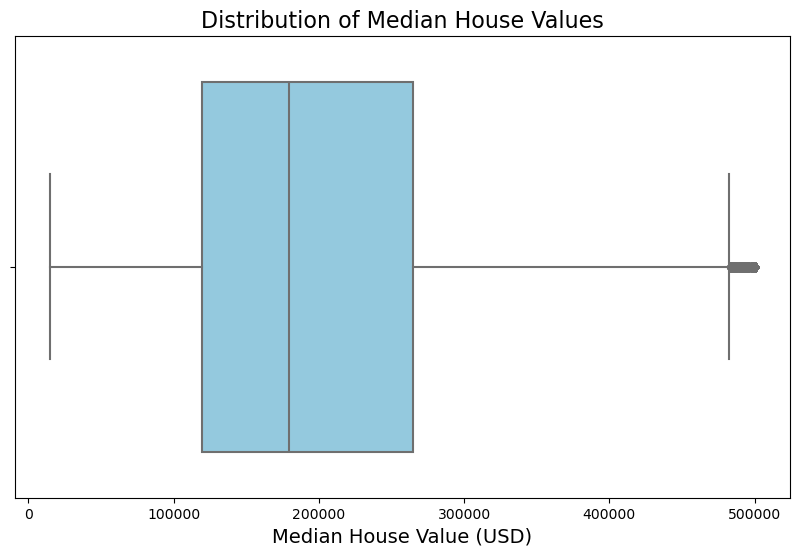

In [67]:
#data visualization 1
#box plot to check if there are outliers in median house value
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['median_house_value'], color='skyblue')
plt.title('Distribution of Median House Values', fontsize=16)
plt.xlabel('Median House Value (USD)', fontsize=14)
plt.show()

The box plot provides a broad overview of house prices in different areas without specific geographic context. It seems like there are some outliers in the data. 

Clearly, there are some data points that lie beyond the upper whisker. Therefore, the plot suggests the presence of outliers on the higher end of median_house_value, i.e. above $500,000.

In [68]:
#checking for how many outliers
outliers = data[data['median_house_value'] > 500000].shape[0]

print(outliers)

958


958 observations are above 500,000 suggesting the distribution is likely right-skewed. Log transformation of this variable will normalize this distribution and help with later analysis and regression models.

In [69]:
import numpy as np

data['log_median_house_value'] = np.log(data['median_house_value'])

print(data[['median_house_value', 'log_median_house_value']].head())

   median_house_value  log_median_house_value
0            452600.0               13.022764
1            358500.0               12.789684
2            352100.0               12.771671
3            341300.0               12.740517
4            342200.0               12.743151


The project aims to analyze the determinants of housing prices in California, with a focus on the impact of proximity to the ocean. It is intuitive that house prices vary based on their distance from the ocean. A violin plot could offer a detailed view of the distribution of house prices across different proximity categories, highlighting key patterns and differences.
 

c:\Users\sindh\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


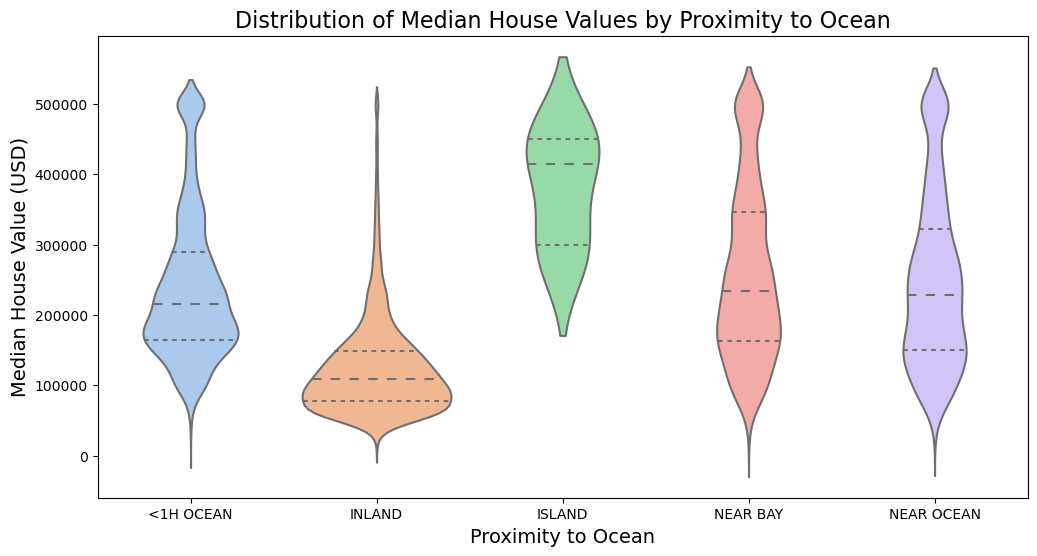

In [70]:
#data visualization 2
plt.figure(figsize=(12, 6))
sns.violinplot(x='ocean_proximity', y='median_house_value', data=data, palette='pastel', inner='quartile')
plt.title('Distribution of Median House Values by Proximity to Ocean', fontsize=16)
plt.xlabel('Proximity to Ocean', fontsize=14)
plt.ylabel('Median House Value (USD)', fontsize=14)
plt.show()

Category '<1H OCEAN' shows a wider spread in higher values compared to 'INLAND', indicating higher variability in house prices close to the ocean. 'NEAR BAY' & 'NEAR OCEAN' have higher medians compared to 'INLAND' suggesting higher average house values closer to the ocean. It seems to pertinent to include ocean proximity as fixed effect and interaction term (to capture differential effects) in the regression analysis.

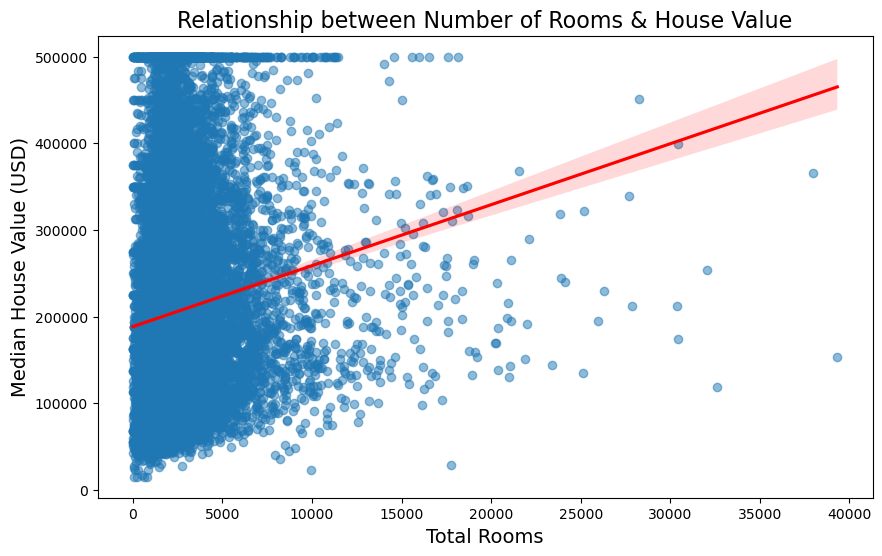

In [71]:
#data visualization 3
#scatterplot of number of rooms with median house value with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='total_rooms', y='median_house_value', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Number of Rooms & House Value', fontsize=16)
plt.xlabel('Total Rooms', fontsize=14)
plt.ylabel('Median House Value (USD)', fontsize=14)
plt.show()

The upward sloping regression line in the scatter plot indicates a positive correlation between the number of rooms and house value. This suggests that houses with more rooms in the block tend to have higher median values. The dense clustering of data points at the lower end (fewer than 5,000 rooms) implies that:

- majority of houses in the dataset have a relatively small number of rooms
- a wide range of house values (lower to higher) indicating variability in house prices even within blocks with fewer rooms

Additionally, it seems like there is some sort of capping at $500,000, since there is a horizontal line of data points.

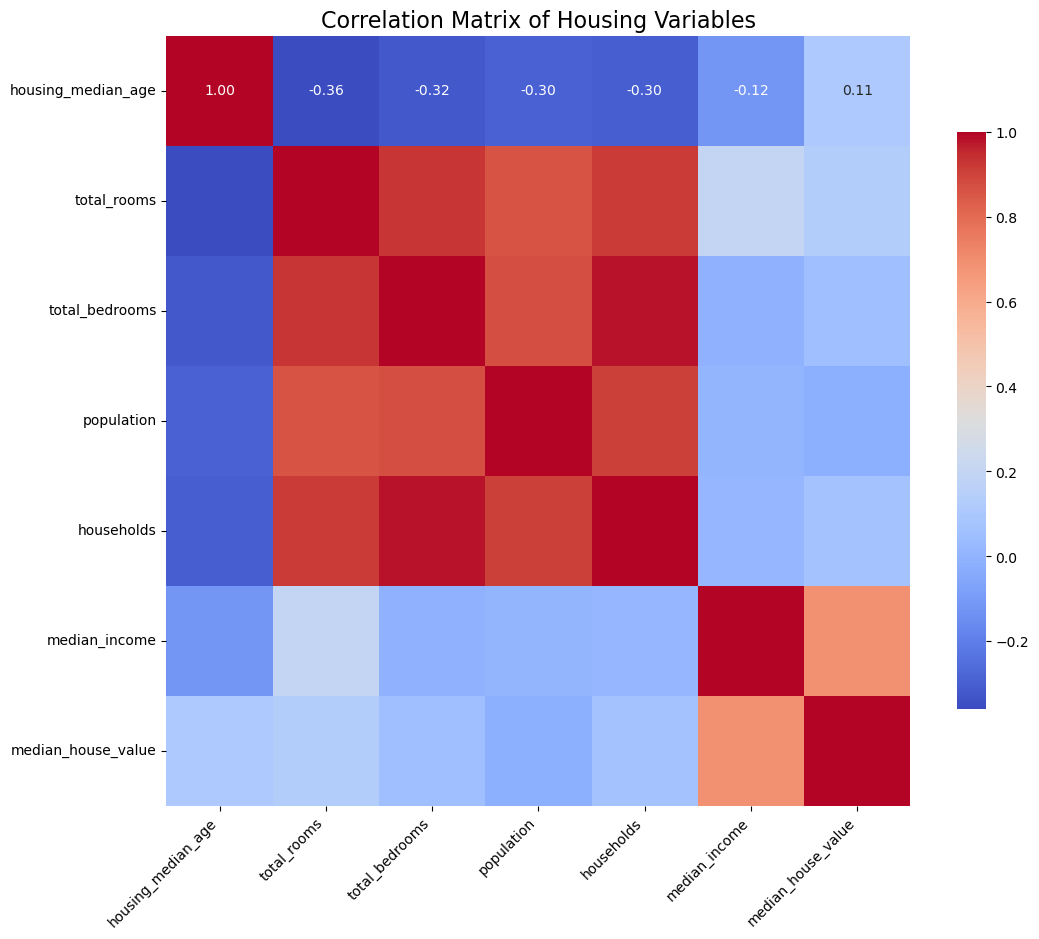

In [72]:
#data visualisation 4
#heatmap 
variables = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
correlation_matrix = data[variables].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10}, cbar_kws={'shrink': 0.75})
plt.title('Correlation Matrix of Housing Variables', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

The heatmap shows correlations among housing variables, with red indicating positive and blue indicating negative relationships. 

Median_income strongly correlates with median_house_value (~ 0.7), suggesting higher incomes lead to higher house prices. Total_rooms, total_bedrooms, and households are highly interrelated, indicating larger blocks have more rooms and households. Housing_median_age negatively correlates with these variables, implying older blocks tend to have fewer rooms and smaller populations. Population moderately correlates with room-related variables but has little direct effect on house values. This highlights income as a key factor in housing prices, while block size variables are more interrelated without directly influencing house values.

In [73]:
#data visualization 5
from prettytable import PrettyTable

summary_statistics = data[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].describe()

#creating a PrettyTable object
table = PrettyTable()

#adding columns & rows
table.field_names = ["Statistic"] + list(summary_statistics.columns)
for row in summary_statistics.itertuples():
    table.add_row(row)

print(table)

+-----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
| Statistic | housing_median_age |    total_rooms     |   total_bedrooms  |     population     |     households     |   median_income    |
+-----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|   count   |      20433.0       |      20433.0       |      20433.0      |      20433.0       |      20433.0       |      20433.0       |
|    mean   | 28.633093525179856 | 2636.5042333480155 | 537.8705525375618 | 1424.9469485635982 | 499.43346547251997 | 3.8711616013311794 |
|    std    | 12.591805202182773 | 2185.269566977597  | 421.3850700740322 | 1133.2084897449563 | 382.2992258828491  | 1.899291249306252  |
|    min    |        1.0         |        2.0         |        1.0        |        3.0         |        1.0         |       0.4999       |
|    25%    |        18.0  

The median age of houses (housing_median_age) is 29 years, with a wide range from 1 to 52 years, indicating diverse house age profiles.

Total_rooms and total_bedrooms show significant variability, with mean values of 2636 and 538, respectively, but maximum values suggested aggregated data, i.e. these variables are for houses in the block. Median_income averages around $38,711, with a range from approximately $5000 to $150,001, reflecting economic diversity among households. The variability in these statistics underscores the heterogeneity  of housing characteristics in the dataset.

### Methodology

The paper would relies on Python libraries of Numpy, Pandas and Statsmodels learnt in class. Firstly, the dataset will be cleaned and split into a training and test set. OLS will be primarily used in its vanilla form as well with fixed effects and interaction terms. The paper would also apply lasso and ridge regression techniques to evaluate which variables are most relevant to the outcome variable. Machine learning methods of Decision Trees and Random Forests will also be applied to facilitate a comparative analysis of performance of different models. The model performance will be assessed using the out-of-sample R2 measure and, k-fold cross-validation (CV) will also be used to evaluate the predictive performance of multiple models to choose the best one. Time permitting, I intend to also explore other techniques learnt such as bootstrapping and quantile regression techniques.


##### Splitting the Dataset into Train & Test Sets 

In [75]:
#splitting into train & test set
from sklearn.model_selection import train_test_split

#hot encoding of categorical variable
data_encoded = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)

data_encoded['log_median_house_value'] = np.log(data_encoded['median_house_value'])

#defining X and y
X = data_encoded.drop(['median_house_value', 'log_median_house_value'], axis=1)  #dropping target variables
y = data_encoded['log_median_house_value']  #defining the target variable

#splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



##### Running different models

##### Model 1: OLS with fixed effects

In [76]:
#running a simple OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model1 = LinearRegression(fit_intercept=False)

#fitting model on the training set
model1.fit(X_train, y_train)

#predicting on test set
y_pred = model1.predict(X_test)

#calculating R-squared value on the test set (i.e. the Out-of-Sample R2 measure)
m1_r2 = r2_score(y_test, y_pred)
print(f"OOS R-squared for Model 1: {m1_r2:.4f}")

OOS R-squared for Model 1: 0.6714


##### Model 2: OLS with Fixed Effects & Interaction Terms


This model is run with the following inetraction terms:

- median_income * total_rooms: captures the interaction between household income and number of rooms. It is relevant because higher-income households might prefer larger homes, and the effect of income on house value could be more pronounced for houses with more rooms.

- housing_median_age * total_rooms: reflects how the age of the housing might influence the value of larger houses differently than smaller ones.

In [77]:
#creating interaction terms
X_train['income_rooms'] = X_train['median_income'] * X_train['total_rooms']
X_train['age_rooms'] = X_train['housing_median_age'] * X_train['total_rooms']

X_test['income_rooms'] = X_test['median_income'] * X_test['total_rooms']
X_test['age_rooms'] = X_test['housing_median_age'] * X_test['total_rooms']

model2 = LinearRegression(fit_intercept=False)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
m2_r2 = r2_score(y_test, y_pred)
print(f"OOS R-squared for Model 2: {m2_r2:.4f}")

OOS R-squared for Model 2: 0.6731


##### Model 3: OLS Fixed Effects, Intercation Terms and Dummay Variables for SF & LA

Adding these dummy variables since house prices in large cities are much higher than elsewhere.

In [78]:
#defining approximate latitude and longitude ranges for SF and LA
# San Francisco
SF_lat_min, SF_lat_max = 37.6, 37.9
SF_lon_min, SF_lon_max = -123.0, -122.3

# Los Angeles
LA_lat_min, LA_lat_max = 33.7, 34.3
LA_lon_min, LA_lon_max = -118.7, -118.2


#adding dummy variables into the train & test set
X_train['is_SF'] = ((X_train['latitude'] >= SF_lat_min) & (X_train['latitude'] <= SF_lat_max) &
                     (X_train['longitude'] >= SF_lon_min) & (X_train['longitude'] <= SF_lon_max)).astype(int)

X_train['is_LA'] = ((X_train['latitude'] >= LA_lat_min) & (X_train['latitude'] <= LA_lat_max) &
                    (X_train['longitude'] >= LA_lon_min) & (X_train['longitude'] <= LA_lon_max)).astype(int)

X_test['is_SF'] = ((X_test['latitude'] >= SF_lat_min) & (X_test['latitude'] <= SF_lat_max) &
                   (X_test['longitude'] >= SF_lon_min) & (X_test['longitude'] <= SF_lon_max)).astype(int)

X_test['is_LA'] = ((X_test['latitude'] >= LA_lat_min) & (X_test['latitude'] <= LA_lat_max) &
                   (X_test['longitude'] >= LA_lon_min) & (X_test['longitude'] <= LA_lon_max)).astype(int)

model3 = LinearRegression(fit_intercept=True)  # Intercept is usually recommended
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
m3_r2 = r2_score(y_test, y_pred)
print(f"OOS R-squared for Model 3: {m3_r2:.4f}")

OOS R-squared for Model 3: 0.6875


##### Model 4: Lasso with 5 K-fold CV

In [81]:
#confirming X train & test includes all variables
print(X_train.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'income_rooms', 'age_rooms', 'is_SF', 'is_LA'],
      dtype='object')


In [82]:
from sklearn.linear_model import LassoCV

model4 = LassoCV(cv=5, random_state=42)

model4.fit(X_train, y_train)

#creating a dataFrame to hold feature names and their coefficients
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model4.coef_
})

#printing the top three coefficients picked Lasso in absolute magnitude
top_coefficients = coefficients_df.reindex(coefficients_df.Coefficient.abs().sort_values(ascending=False).index[:3])

print("Top 3 coefficients by absolute magnitude:")
print(top_coefficients)

Top 3 coefficients by absolute magnitude:
       Feature  Coefficient
6   households     0.000266
3  total_rooms    -0.000230
5   population    -0.000094


In [86]:
best_lambda = model4.alpha_
print(f"Best lambda selected by cross-validation: {best_lambda:.4f}")

y_pred = model4.predict(X_test)

m4_r2 = r2_score(y_test, y_pred)
print(f"OOS R-squared for Model 4 (Lasso) with best lambda: {m4_r2:.4f}")


Best lambda selected by cross-validation: 6.0667
OOS R-squared for Model 4 (Lasso) with best lambda: 0.3145


However, the R2 measure has reduced. So this model does not seem to be performing well.

##### Model 5: Ridge Model using 5 K-fold CV

In [87]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-6, 6, 13)
model5 = RidgeCV(alphas=alphas, cv=5, scoring='r2')
model5.fit(X_train, y_train)
best_alpha = model5.alpha_
print(f"Best alpha (lambda) selected by cross-validation: {best_alpha:.4f}")

Best alpha (lambda) selected by cross-validation: 0.1000


In [88]:
y_pred = model5.predict(X_test)
m5_r2 = r2_score(y_test, y_pred)
print(f"OOS R-squared for Ridge model with best alpha: {m5_r2:.4f}")

OOS R-squared for Ridge model with best alpha: 0.6875


##### Model 6: Random Forests

In [89]:
from sklearn.ensemble import RandomForestRegressor

model6 = RandomForestRegressor(n_estimators=100,  max_depth=None, random_state=42, n_jobs=-1)
model6.fit(X_train, y_train)
y_pred = model6.predict(X_test)
rf_r2 = r2_score(y_test, y_pred)
print(f"OOS R-squared for Random Forest model: {rf_r2:.4f}")

OOS R-squared for Random Forest model: 0.8387


Evidently, Random Forests has the best OOS R2. This is intutive since RF is a complex and relatively better ML technique.

##### Model 7: Quantile Regression

In [92]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,log_median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,13.022764
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,12.789684
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,12.771671
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,12.740517
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,12.743151


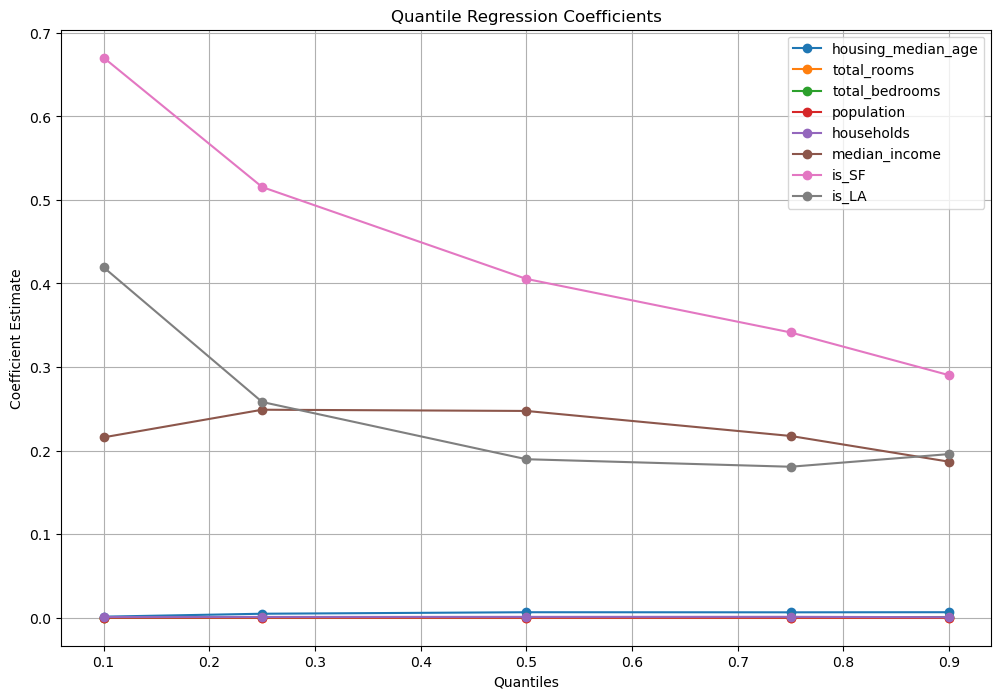

In [96]:
import statsmodels.formula.api as smf

data['is_SF'] = ((data['latitude'] >= SF_lat_min) & (data['latitude'] <= SF_lat_max) &
                     (data['longitude'] >= SF_lon_min) & (data['longitude'] <= SF_lon_max)).astype(int)

data['is_LA'] = ((data['latitude'] >= LA_lat_min) & (data['latitude'] <= LA_lat_max) &
                    (data['longitude'] >= LA_lon_min) & (data['longitude'] <= LA_lon_max)).astype(int)

features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'is_SF', 'is_LA']

formula = 'log_median_house_value ~ ' + ' + '.join(features)

# Defining the quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Fitting the quantile regression models
models = {}
for q in quantiles:
    model = smf.quantreg(formula, data).fit(q=q)
    models[q] = model

# Extracting coefficients for each quantile
coefficients = {q: model.params for q, model in models.items()}
coef_df = pd.DataFrame(coefficients)

# Plotting the coefficients for each predictor across different quantiles
plt.figure(figsize=(12, 8))
for feature in features:
    plt.plot(quantiles, coef_df.loc[feature], label=feature, marker='o')

plt.xlabel('Quantiles')
plt.ylabel('Coefficient Estimate')
plt.title('Quantile Regression Coefficients')
plt.legend()
plt.grid(True)
plt.show()

The plot highlights the heterogenous effects. Explaining each coefficient for the Quantile Regression

- The coefficient for housing_median_age, population & total_rooms is close to zero across all quantiles suggesting that the age of the housing does not have a significant impact on house prices across the distribution. Appears to be the case that other factors are more influential in determining house prices.

- Variable households has a decreasing trend from higher coefficients in lower quantiles to lower coefficients in higher quantiles, suggesting that the number of households is more influential in lower-priced segments of the market. As house prices increase, the effect of households becomes less significant.

- Variable median_income remains relatively stable and positive across all quantiles, indicating that higher median incomes are associated with higher house prices uniformly across the market. This implies that income is a consistent and strong determinant of house prices.

- Dummy Variables (SF & LA) is_SF decreases from around 0.7 at the 10th percentile to approximately 0.3 at the 90th percentile. This indicates that being located in San Francisco has a substantial positive effect on house prices (as expected), especially in the lower price segments. The effect diminishes as prices increase, suggesting that the premium for being in San Francisco is more pronounced for lower-priced properties.
is_LA shows a consistent effect across quantiles, with coefficients around 0.2. This implies that being located in Los Angeles increases house prices by a consistent margin across the distribution, reflecting the city’s uniformly higher housing costs.



#### Conclusions

The project set out to answer which varaibles are the key determinants for hosuing prices in california and also do a comparative analysis of different ML techniques. Following are some conclusions:

- Random Forests (Model 7) has the best Out-of-sample R-squared measure with 0.8387 i.e. the model is able to explain upto 83% variability in the test data. 

- Number of room for houses in a block, location of the houses and proximity to ocean is key important variables in determining house prices in California.